In [2]:
import os
import tqdm
import rasterio
import numpy as np
from matplotlib import pyplot as plt
from torch.distributions import Normal
import torch
from scipy.stats import norm as scipy_norm

In [7]:
data_path = "/scratch/project_2003104/gtikhono/bird_app/data"
sp_list = os.listdir(data_path)
sp_list.sort()
print(sp_list)
sp_dir = sp_list[0]

['acanthis_flammea', 'accipiter_gentilis', 'accipiter_nisus', 'acrocephalus_arundinaceus', 'acrocephalus_dumetorum', 'acrocephalus_palustris', 'acrocephalus_schoenobaenus', 'acrocephalus_scirpaceus', 'actitis_hypoleucos', 'aegithalos_caudatus', 'aegolius_funereus', 'alauda_arvensis', 'alca_torda', 'alcedo_atthis', 'anas_acuta', 'anas_crecca', 'anas_platyrhynchos', 'anser_albifrons', 'anser_anser', 'anser_brachyrhynchus', 'anser_erythropus', 'anser_fabalis', 'anthus_campestris', 'anthus_cervinus', 'anthus_petrosus', 'anthus_pratensis', 'anthus_trivialis', 'apus_apus', 'aquila_chrysaetos', 'ardea_alba', 'ardea_cinerea', 'arenaria_interpres', 'asio_flammeus', 'asio_otus', 'aythya_ferina', 'aythya_fuligula', 'aythya_marila', 'bombycilla_garrulus', 'botaurus_stellaris', 'branta_bernicla', 'branta_canadensis', 'branta_leucopsis', 'bubo_bubo', 'bubo_scandiacus', 'bucephala_clangula', 'buteo_buteo', 'buteo_lagopus', 'calcarius_lapponicus', 'calidris_alba', 'calidris_alpina', 'calidris_canutus'

In [38]:
with rasterio.open(os.path.join(data_path, sp_dir, sp_dir+"_a.tif")) as src:
    a_map, profile = src.read(1), src.profile

with rasterio.open(os.path.join(data_path, sp_dir, sp_dir+"_vaL.tif")) as src:
    vaL_map = src.read(1)

vaL_map[(np.isnan(vaL_map))&(~np.isnan(a_map))] = 1.0 # ensure a_map != nan implies va_map != nan
vaL_map[np.isnan(a_map)] = np.nan
aL_map = scipy_norm.ppf(a_map)
idx = ~np.isnan(vaL_map)

#

In [47]:
n_mc = 100
va_map = np.nan * vaL_map
aL1, vaL1_sqrt = torch.tensor(aL_map[idx]), torch.tensor(np.sqrt(vaL_map[idx]))
dn = Normal(torch.tensor([0.0]), torch.tensor([1.0]))
E_Phi, E_Phi_squared = torch.zeros_like(aL1), torch.zeros_like(vaL1_sqrt)
for _ in tqdm.tqdm(range(n_mc)):
    L_sample = aL1 + vaL1_sqrt*dn.sample()
    p_sample = dn.cdf(torch.tensor(L_sample))
    E_Phi += p_sample
    E_Phi_squared += p_sample**2

E_Phi /= n_mc
E_Phi_squared /= n_mc
va_map[idx] = (E_Phi_squared - E_Phi**2).numpy()

/tmp/gtikhono/27164575/ipykernel_2974057/2215396907.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p_sample = dn.cdf(torch.tensor(L_sample))

00%|██████████| 100/100 [01:53<00:00,  1.14s/it]

In [62]:
n_mc = 100
bn = 10
va_map = np.nan * vaL_map
aL1, vaL1_sqrt = torch.tensor(aL_map[idx,None]), torch.tensor(np.sqrt(vaL_map[idx,None]))
dn = Normal(torch.tensor([0.0]*bn), torch.tensor([1.0]*bn))
E_Phi, E_Phi_squared = torch.zeros_like(aL1), torch.zeros_like(vaL1_sqrt)
for _ in tqdm.tqdm(range(n_mc // bn)):
    L_sample = aL1 + vaL1_sqrt*dn.sample()
    p_sample = dn.cdf(torch.tensor(L_sample))
    E_Phi += torch.sum(p_sample, -1)
    E_Phi_squared += torch.sum(p_sample**2, -1)

E_Phi /= n_mc
E_Phi_squared /= n_mc
va_map[idx] = (E_Phi_squared - E_Phi**2).numpy()

/tmp/gtikhono/27164575/ipykernel_2974057/1665472001.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p_sample = dn.cdf(torch.tensor(L_sample))

 0%|          | 0/10 [00:08<?, ?it/s]

RuntimeError: output with shape [33065965, 1] doesn't match the broadcast shape [33065965, 33065965]

In [66]:
E_Phi.shape

torch.Size([33065965, 1])

In [17]:
with rasterio.open(os.path.join(data_path, sp_dir, sp_dir+"_va.tif"), "w", **profile) as dst:
    dst.write(va_map.astype(np.float32), 1)

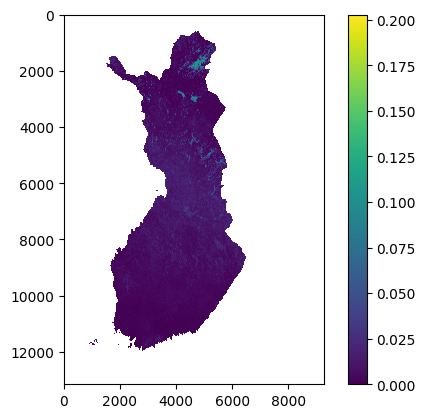

In [49]:
plt.imshow(va_map)
plt.colorbar();

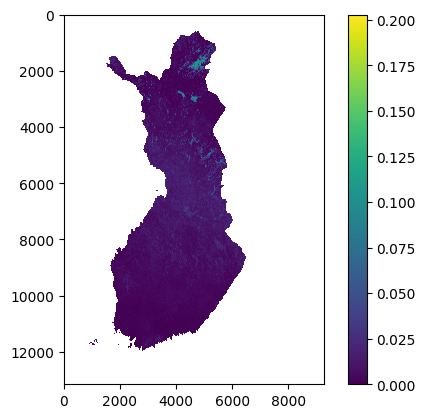

In [48]:
plt.imshow(va_map)
plt.colorbar();